In [1]:
import sys
import os

import matplotlib.pyplot as plt

from src.model import *

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import math

from tqdm import tqdm
from IPython.display import clear_output

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

In [7]:
class MyDataset:

    def __init__(self, X, y, X_weak=None, batch_size=64):
        self._len_X = X.shape[0]
        if X_weak is not None:
            self._len_X_weak = X_weak.shape[0]
            self.X_weak = torch.Tensor(X_weak)
        else:
            self._len_X_weak = 0
            self.X_weak = None
            
        self._len_y = y.shape[0]
        
        self.X = torch.Tensor(X)
        if len(y.shape) == 1:
            self.y = torch.Tensor(y)[:, None]
        else:
            self.y = torch.Tensor(y)
        self._batch_size = batch_size
        self._batch_size_weak = batch_size*self._len_X_weak//self._len_X
        self.max = math.ceil(self._len_X/self._batch_size)

    def __iter__(self):
        self.n = 0
        self.idxes_X = torch.randperm(self._len_X)
        self.idxes_y = torch.randperm(self._len_y)
        self.idxes_X_weak = torch.randperm(self._len_X_weak)
        return self
    
    def __len__(self):
        return self.max

    def __next__(self):
        if self.n < self.max:
            self.n += 1
            if self._len_X_weak:
                return (self.X[(self.n-1)*self._batch_size:self.n*self._batch_size],
                        self.X_weak[(self.n-1)*self._batch_size_weak:self.n*self._batch_size_weak],
                        self.y[(self.n-1)*self._batch_size:self.n*self._batch_size])
            
            return (self.X[self.idxes_X],
                    self.y[self.idxes_y])
        else:
            raise StopIteration

In [1]:
cfg = {
    "lbl": "train_4_standard_best",
    "desc": "predicts point of size 4 from standard scaled train data",
    "data_suffix": "_standard",
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 1000,
    "betas": [0, 0.99],
    "lr": 1e-3,
    "batch_size": 250,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "metrics_freq": 10,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "num_pred_rows": 410,
    "num_reps": 10000,
    "finetune": True,
    "from_ckpt": True,
    "from_epoch": 2
}

cfg_dataset = {
    'n_samples_train':250,
    'n_samples_test':250,
    'n_samples_weak':750,
}

cfg_make_regression = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_test']\
                +cfg_dataset['n_samples_weak'],
    'n_features':50,
    'n_informative':10,
    'n_targets':1,
    'shuffle':True
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

test_size = 0.25
X, y = make_regression(**cfg_make_regression)
X_train, X_test, y_train, y_test = train_test_split(*make_regression(**cfg_make_regression),
                                                    test_size=cfg_dataset["n_samples_test"])
X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]

train_loader = MyDataset(X_train, y_train, X_weak, cfg["batch_size"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"])

NameError: name 'torch' is not defined

In [16]:
cfg_model = {
    "z_dim":cfg_make_regression["n_features"],
    "gen_dims": [cfg_make_regression["n_targets"]],
    "disc_dims":[cfg_make_regression["n_targets"]]
}

netG = Generator(cfg_model)
netD = Discriminator(cfg_model)

cfg_opt = {
    'betas':[0, 0.99],
    'lr':1e-3,
}

optimG = Adam(filter(lambda p: p.requires_grad, netG.parameters()), **cfg_opt)
optimD = Adam(filter(lambda p: p.requires_grad, netD.parameters()), **cfg_opt)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

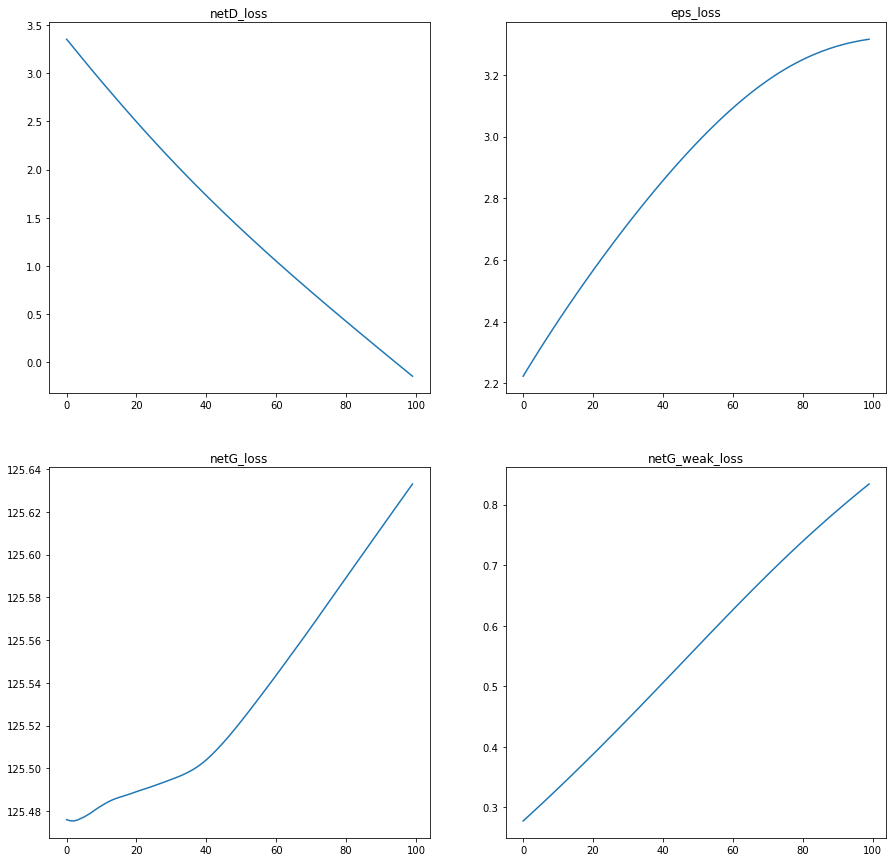

In [19]:
losses = [[], [], [], []]

for e in range(cfg['num_epochs']):
    for X_batch, X_batch_weak, y_batch in train_loader:
        optimD.zero_grad()
        fake = netG(X_batch.to(cfg['device']))
        real = y_batch.to(cfg['device'])


        e_fake = netD(fake).mean()
        e_real = netD(real).mean()

        netD_loss = e_real - e_fake

        meters['netD_real_loss'].update(e_real.item())
        meters['netD_fake_loss'].update(e_fake.item())

        eps_pen = e_real ** 2
        eps_loss = eps_pen.mean()
        meters['eps_loss'].update(eps_loss.item())

        mix_alpha = torch.rand((len(real), cfg['batch_size'], 1), device=cfg['device'])
        mixed = mix_alpha * real + (1 - mix_alpha) * fake
        mixed.requires_grad_(True)
        mixed_preds = netD(mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(real), cfg['batch_size'], -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
        meters['grad_loss'].update(grad_loss.item())

        netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
        meters['netD_loss'].update(netD_total_loss.item())
        netD_total_loss.backward()
        optimD.step()

        optimG.zero_grad()
        optimD.zero_grad()
        fake = netG(X_batch.requires_grad_(True))
        netG_pred = netD(fake)
        netG_loss = -netG_pred.mean()

        grad_loss = ((grads.norm(2, dim=-1)) ** 2).mean()
        with torch.no_grad():
            L2Loss = ((((fake - real)**2).sum(axis=1))**(1/2)).mean()
            meters['netG_loss'].update(L2Loss.item())
        meters['netG_weak_loss'].update(grad_loss.item())
        
        #fake_weak = netG(X_batch_weak.requires_grad_(True))
        #grads = torch.autograd.grad(
        #    outputs=fake_weak.sum(),
        #    inputs=X_batch_weak,
        #    create_graph=True,
        #    retain_graph=True,
        #)[0]
        
        netG_loss_total = netG_loss
        netG_loss_total.backward()
        optimG.step()
        
    if not e % 10:
        clear_output(wait=True)
        losses[0].append(meters["netD_loss"].avg)
        losses[1].append(meters["eps_loss"].avg)
        losses[2].append(meters["netG_loss"].avg)
        losses[3].append(meters["netG_weak_loss"].avg)
        
        plt.figure(figsize=(15, 15))
        ax1 = plt.subplot(221)
        ax2 = plt.subplot(222)
        ax3 = plt.subplot(223)
        ax4 = plt.subplot(224)
        
        ax1.set_title("netD_loss")
        ax1.plot(losses[0])
        
        ax2.set_title("eps_loss")
        ax2.plot(losses[1])
        
        ax3.set_title("netG_loss")
        ax3.plot(losses[2])
        
        ax4.set_title("netG_weak_loss")
        ax4.plot(losses[3])
        
        plt.show()